In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Resize all images to 75x75 (needed for InceptionV3)
x_train = tf.image.resize(x_train, [75, 75]).numpy()
x_test = tf.image.resize(x_test, [75, 75]).numpy()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training data shape: (50000, 75, 75, 3)
Test data shape: (10000, 75, 75, 3)


In [3]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [4]:
def build_and_train_model(base_model, model_name):
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"\nTraining {model_name}...")

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=64),
        epochs=5,
        validation_data=(x_test, y_test),
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    return history, test_acc

In [5]:
input_shape = (75, 75, 3)  # resized input shape

vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-1447665233.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
results = {}
histories = {}

models = {
    "VGG16": vgg,
    "ResNet50": resnet,
    "InceptionV3": inception,
    "MobileNetV2": mobilenet
}

for name, model_base in models.items():
    hist, acc = build_and_train_model(model_base, name)
    results[name] = acc
    histories[name] = hist


Training VGG16...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 132ms/step - accuracy: 0.4315 - loss: 1.6199 - val_accuracy: 0.6083 - val_loss: 1.1311
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 122ms/step - accuracy: 0.5778 - loss: 1.2057 - val_accuracy: 0.6371 - val_loss: 1.0470
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 122ms/step - accuracy: 0.5983 - loss: 1.1492 - val_accuracy: 0.6331 - val_loss: 1.0539
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step - accuracy: 0.6108 - loss: 1.1121 - val_accuracy: 0.6482 - val_loss: 0.9954
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step - accuracy: 0.6228 - loss: 1.0876 - val_accuracy: 0.6511 - val_loss: 1.0026
VGG16 Test Accuracy: 0.6511

Training ResNet50...
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 115s 133ms/step - accuracy: 0.1642 - loss: 2.2305 - val_accuracy: 0.2914 - val_loss: 1.9766
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 116ms/step - accuracy: 0.2627 - loss: 2.0051 - val_accuracy: 0.3053 - val_loss: 1.8996
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━

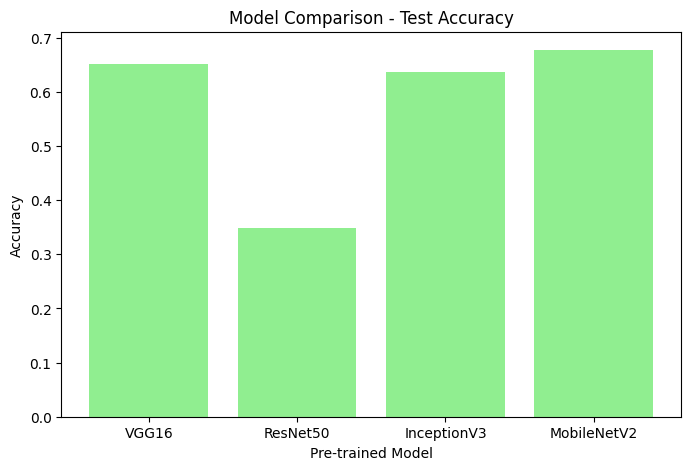

In [7]:
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color='lightgreen')
plt.title("Model Comparison - Test Accuracy")
plt.xlabel("Pre-trained Model")
plt.ylabel("Accuracy")
plt.show()


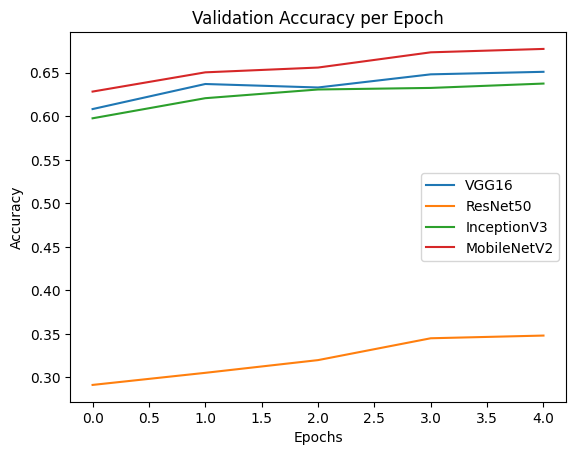

In [8]:
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=name)

plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [9]:
for name, acc in results.items():
    print(f"{name}: Test Accuracy = {acc:.4f}")

best_model = max(results, key=results.get)
print(f"\nBest performing model: {best_model} with accuracy {results[best_model]:.4f}")

VGG16: Test Accuracy = 0.6511
ResNet50: Test Accuracy = 0.3481
InceptionV3: Test Accuracy = 0.6376
MobileNetV2: Test Accuracy = 0.6774

Best performing model: MobileNetV2 with accuracy 0.6774
